In [53]:
#### Settings ###########
import seaborn as sns

sns.set()
import pandas as pd

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
import matplotlib.pyplot as plt

plt.style.use("classic")
plt.rcParams["figure.figsize"] = [10, 5]
%load_ext nb_black

<IPython.core.display.Javascript object>

Há um projeto no Datacamp chamado <b>Classify Song Genres from Audio Data</b>. Nele, construímos um modelo de árvore de decisão, com redução de dimensionalidade via PCA, para classificar estilos musicais. O projeto possui uma falha de Data Leakage e acredito que a estrutura possa ser melhorada com um Pipeline. Este notebook fará essas alterações para explorar um código melhor estruturado e um modelo com melhor acurácia.

Primeiro, o projeto rodou uma árvore de decisão e obteve acurácia de 86%. Em seguida, testou-se uma regressão logística, que atingiu 89%. Abaixo, o classification report dos dois modelos testados:
<img src='modelo_desbalanceado.png'>

Em seguida, construiu-se modelos com os dados balanceados. Nesse caso, a acurácia foi de 77% e 83%. O classification report:
<img src='modelo_balanceado.png'>

## MELHORIA COM PIPELINE + RANDOM FOREST

In [3]:
# Import libraris
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('echonest-metrics.json',precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics,
                       tracks[['track_id','genre_top']],
                       on='track_id')

# Inspect the resultant dataframe
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [4]:
# Define our features 
features = echo_tracks.drop(columns=['genre_top', 'track_id'], axis=1)

# Define our labels
labels = echo_tracks['genre_top']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0)

In [36]:
# MODELO COM PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# Criando o Preprocessamento no Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.columns)])

# Pipeline com random forest
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


# Fita o modelo
rf.fit(X_train, y_train)

# predicoes
y_pred = rf.predict(X_test)

# Acurácia do modelo
from sklearn.metrics import accuracy_score
print("Random Forest Accuracy: \n",accuracy_score(y_test, y_pred))

# Classification report
from sklearn.metrics import classification_report
class_rep_rf = classification_report(y_test, y_pred)

print("Random Forest: \n", class_rep_rf)

# Matriz de Confusao
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Random Forest Accuracy: 
 0.9109075770191507
Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.71      0.76       237
        Rock       0.93      0.96      0.95       964

    accuracy                           0.91      1201
   macro avg       0.87      0.84      0.85      1201
weighted avg       0.91      0.91      0.91      1201



array([[169,  68],
       [ 39, 925]])

In [38]:
# Avaliação com kfold
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Set up our K-fold cross-validation
kf = KFold(n_splits=10, random_state=10)

rf = RandomForestClassifier(random_state=10)

# Train our models using KFold cv
rf_score = cross_val_score(rf, X_train, y_train, cv = kf)

# Print the mean of each array of scores
print("Random Forest: ", np.mean(rf_score))

/Users/andremota/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Random Forest:  0.92640350877193


O modelo foi bem melhor que o que foi feito no projeto. O único problema é que está errando bem mais para o hip-hop. <br>
Uma alternativa é usar class weight, alguma técnica de oversampling/undersampling ou simplesmente construir um modelo com amostras balanceadas.<br>
Veremos isso mais para frente.

## RANDOMIZED SEARCH

Vamos tunar os hiperparâmetros da Random Forest, mas com o Randomized porque o Grid vai levar a vida toda.

In [51]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# best model
print(rf_random.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 45.4min finished


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


In [52]:
# MODELO COM PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# Criando o Preprocessamento no Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.columns)])

# Pipeline com random forest
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators= 200,
                                                            min_samples_split=10,
                                                            min_samples_leaf= 1,
                                                            max_features='sqrt',
                                                            max_depth= 40,
                                                            bootstrap= False))])


# Fita o modelo
rf.fit(X_train, y_train)

# predicoes
y_pred = rf.predict(X_test)

# Acurácia do modelo
from sklearn.metrics import accuracy_score
print("Random Forest Accuracy: \n",accuracy_score(y_test, y_pred))

# Classification report
from sklearn.metrics import classification_report
class_rep_rf = classification_report(y_test, y_pred)

print("Random Forest: \n", class_rep_rf)

# Matriz de Confusao
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Random Forest Accuracy: 
 0.9125728559533722
Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.72      0.76       237
        Rock       0.93      0.96      0.95       964

    accuracy                           0.91      1201
   macro avg       0.87      0.84      0.86      1201
weighted avg       0.91      0.91      0.91      1201



array([[170,  67],
       [ 38, 926]])

Veja que o modelo não melhorou, e piorou em alguns casos (f1-score)

## PIPELINE PARA SELEÇÃO DO MODELO

Antes de tentarmos melhorar o balanceamento, vamos só fazer uma brincadeirinha aqui e testar vários modelos com os parâmetros padrão mesmo e ver qual tem melhor resultado. Mera curiosidade.

In [55]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    SVC(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

for classifier in classifiers:
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
    pipe.fit(X_train, y_train)
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))

KNeighborsClassifier(n_neighbors=3)
model score: 0.890
SVC(C=0.025, probability=True)
model score: 0.860
SVC()
model score: 0.908
LogisticRegression()
model score: 0.881
DecisionTreeClassifier()
model score: 0.866
RandomForestClassifier()
model score: 0.911
AdaBoostClassifier()
model score: 0.907
GradientBoostingClassifier()
model score: 0.912


<IPython.core.display.Javascript object>

Curioso, sem brincar com os hiperparâmetros, a Random Forest empatou com Gradient Boosting.

E modelos mais robustos com XGBoost e CatBoost? Será que faz muita diferença?

In [66]:
from catboost import CatBoostClassifier, Pool, cv

model_cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    # learning_rate=0.12655172413793103,
    # iterations=550,
    # border_count=150,
)

model_cb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50)

Learning rate set to 0.043486
0:	test: 0.8737088	best: 0.8737088 (0)	total: 10ms	remaining: 10s
50:	test: 0.9432568	best: 0.9432568 (50)	total: 278ms	remaining: 5.18s
100:	test: 0.9475112	best: 0.9475375 (98)	total: 459ms	remaining: 4.09s
150:	test: 0.9500937	best: 0.9500937 (150)	total: 659ms	remaining: 3.7s
200:	test: 0.9510610	best: 0.9512798 (186)	total: 838ms	remaining: 3.33s
250:	test: 0.9521246	best: 0.9521246 (250)	total: 1.25s	remaining: 3.72s
300:	test: 0.9529518	best: 0.9533414 (283)	total: 1.43s	remaining: 3.33s
350:	test: 0.9533414	best: 0.9534333 (347)	total: 1.68s	remaining: 3.1s
400:	test: 0.9537091	best: 0.9538404 (387)	total: 1.86s	remaining: 2.77s
450:	test: 0.9537616	best: 0.9538447 (409)	total: 2.05s	remaining: 2.5s
500:	test: 0.9539804	best: 0.9541161 (493)	total: 2.23s	remaining: 2.22s
550:	test: 0.9540242	best: 0.9542299 (534)	total: 2.48s	remaining: 2.02s
600:	test: 0.9538447	best: 0.9542343 (563)	total: 2.66s	remaining: 1.77s
650:	test: 0.9532976	best: 0.95423

<IPython.core.display.Javascript object>

In [67]:
y_pred = model_cb.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix : \n" + str(confusion_matrix(y_test, y_pred)))a

              precision    recall  f1-score   support

     Hip-Hop       0.83      0.74      0.78       237
        Rock       0.94      0.96      0.95       964

    accuracy                           0.92      1201
   macro avg       0.88      0.85      0.87      1201
weighted avg       0.92      0.92      0.92      1201

Confusion Matrix : 
[[176  61]
 [ 37 927]]


<IPython.core.display.Javascript object>

In [68]:
cm = confusion_matrix(y_test, y_pred)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
accuracy = (cm[0, 0] + cm[1, 1]) / len(y_test)

accuracy

0.9184013322231473

<IPython.core.display.Javascript object>

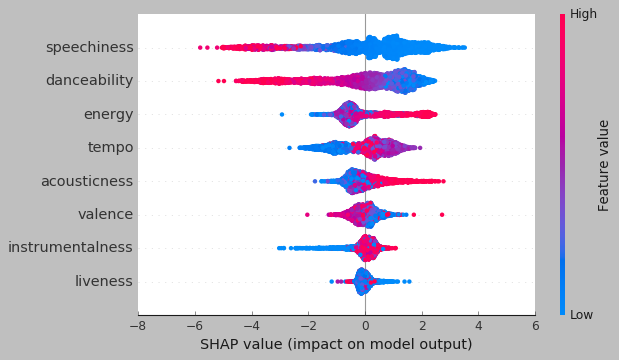

<Figure size 800x400 with 0 Axes>

<IPython.core.display.Javascript object>

In [69]:
# SHAP VALUES
import shap

shap_values = model_cb.get_feature_importance(
    Pool(X_train, y_train,), type="ShapValues",
)

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

shap.summary_plot(shap_values, X_train)

plt.savefig("shap_values")

Beleza, essa brincadeira não levou a lugar algum. Vamos voltar ao jogo sério e usar Class Weight!

## Class Weight

Enfim, vamos finalmente tentar melhorar pra valer esse modelo. Há um problema de balanceamento. Temos algumas alternativas, mas vamos apostar aqui no class_weight. Poderíamos tentar montar datasets com amostras (filtrar o do rock para ficar igual hip-hop) ou usar técnicas de oversampling/undersampling. Porém, <i>class weight</i> é uma boa aposta. Deve dar bom!

In [106]:
from sklearn.metrics import precision_recall_fscore_support as score


def trying_class_weight(class_weight):
    """ FUNÇÃO PARA TESTAR O RESULTADO DE DIFERENTES PESOS PARA AS CLASSES """
    # Criando o Preprocessamento no Pipeline
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[("num", numeric_transformer, X_train.columns)]
    )

    # Pipeline com random forest
    rf = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(class_weight=class_weight)),
        ]
    )

    # Fita o modelo
    rf.fit(X_train, y_train)

    # predicoes
    y_pred = rf.predict(X_test)

    # Matriz de Confusao
    cm = confusion_matrix(y_test, y_pred)
    accuracy = (cm[0, 0] + cm[1, 1]) / len(y_test)

    precision, recall, fscore, support = score(y_test, y_pred, average="macro")

    return accuracy, fscore

<IPython.core.display.Javascript object>

In [107]:
accuracy, fscore = trying_class_weight("balanced")
print(accuracy)
print(fscore)

0.9150707743547044
0.8575942303936612


<IPython.core.display.Javascript object>

In [108]:
accuracy, fscore = trying_class_weight(None)
print(accuracy)
print(fscore)

0.9084096586178185
0.8485630049428228


<IPython.core.display.Javascript object>

In [109]:
accuracy, fscore = trying_class_weight({"Hip-Hop": 1, "Rock": 4})
print(accuracy)
print(fscore)

0.9134054954204829
0.8601800026866073


<IPython.core.display.Javascript object>

Note que já conseguimos ir de 91.00 para 91.26. Além de melhorar o f1-score.<br>
Podemos tentar ainda:
- Aprimorar esse class weight;
- Tunar os hiperparâmetros;
- Tentar um xgboost (que tem levado vários campeonatos por aí).


In [132]:
# Primeiro, melhorando o class weight
# TEM ALGUM ERRO AQUI. CORRIGIR DEPOIS
weights = []
accuracies = []
f1scores = []
for i in np.linspace(0.0, 1, 500):
    accuracy, fscore = trying_class_weight({"Hip-Hop": i, "Rock": 1 - i})
    weights.append(i)
    accuracies.append(accuracy)
    f1scores.append(fscore)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<IPython.core.display.Javascript object>

In [133]:
# Pega o peso de onde teve maior acurácia
weights[accuracies.index(max(accuracies))]

0.3787575150300601

<IPython.core.display.Javascript object>

In [128]:
0.8457286432160804 / 0.15427135678391957

5.482084690553747

<IPython.core.display.Javascript object>

In [157]:
# BELEZA, VAMOS RODAR O MODELO COM O NOVO PESO (APESAR DO LOOP JA TER FEITO PARTE DISSO)
# Parece ter algo de errado, cada hora sai um resultado
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, X_train.columns)]
)

# Pipeline com random forest
rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                class_weight={
                    "Hip-Hop": 0.8457286432160804,
                    "Rock": 0.15427135678391957,
                }
            ),
        ),
    ]
)


# Fita o modelo
rf.fit(X_train, y_train)

# predicoes
y_pred = rf.predict(X_test)

# Acurácia do modelo
print("Random Forest Accuracy: \n", accuracy_score(y_test, y_pred))

# Classification report
class_rep_rf = classification_report(y_test, y_pred)
print("Random Forest: \n", class_rep_rf)

# Matriz de Confusao
confusion_matrix(y_test, y_pred)

Random Forest Accuracy: 
 0.9150707743547044
Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.70      0.77       237
        Rock       0.93      0.97      0.95       964

    accuracy                           0.92      1201
   macro avg       0.88      0.84      0.86      1201
weighted avg       0.91      0.92      0.91      1201



array([[167,  70],
       [ 32, 932]])

<IPython.core.display.Javascript object>

In [158]:
# SERÁ QUE O THRESHOLD PADRÃO(0.5) É O MELHOR?
pred = rf.predict_proba(X_test)[:, 1]

from datetime import datetime
from datetime import timedelta

thresh = 0.10
dummy_list = []
date = datetime.today()

i = 0
while thresh <= 0.90:
    pred_values = np.where(pred >= thresh, "Rock", "Hip-Hop")
    cm = confusion_matrix(y_test, pred_values)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    accuracy = (cm[0, 0] + cm[1, 1]) / len(y_test)
    dummy_list.append([date, thresh, sensitivity, specificity, accuracy])
    thresh += 0.05
    i = i + 1

pd.DataFrame(
    dummy_list, columns=["date", "threshold", "sensitivity", "specificity", "accuracy"]
).sort_values(by="threshold", ascending=False)

,date,threshold,sensitivity,specificity,accuracy
15,2020-12-13 00:16:06.433148,0.85,0.857884,0.907173,0.867610
14,2020-12-13 00:16:06.433148,0.80,0.887967,0.881857,0.886761
13,2020-12-13 00:16:06.433148,0.75,0.905602,0.860759,0.896753
12,2020-12-13 00:16:06.433148,0.70,0.920124,0.822785,0.900916
11,2020-12-13 00:16:06.433148,0.65,0.936722,0.789030,0.907577
10,2020-12-13 00:16:06.433148,0.60,0.949170,0.759494,0.911740
9,2020-12-13 00:16:06.433148,0.55,0.959544,0.725738,0.913405
8,2020-12-13 00:16:06.433148,0.50,0.966805,0.696203,0.913405
7,2020-12-13 00:16:06.433148,0.45,0.973029,0.654008,0.910075
6,2020-12-13 00:16:06.433148,0.40,0.983402,0.611814,0.910075


<IPython.core.display.Javascript object>

## OUTRAS MELHORIAS

In [ ]:
# Tunar hiperparametros
# Tentar outros thresholds